In [107]:
#Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model)
from mesa import Agent, Model

#Para que los agentes se activen al mismo tiempo
from mesa.time import SimultaneousActivation

#Lo usaremos para obtener información de cada paso de la simulación
from mesa.datacollection import DataCollector

#Para poder utilizar varios espacios al mismo tiempo
from mesa.space import MultiGrid

#Lo vamos a usar para crear la animación
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

#Genera números aleatorios
import random

#Importamos los siguientes paquetes para el mejor manejo de valores numéricos
import numpy as np
import pandas as pd

#Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo
import time
import datetime

In [108]:
def get_grid(model):
    """ Esta función nos permite obtener el estado de los diferentes agentes.
        *param* model : Modelo del que obtendrá la información. 
        *return* una matriz con la información del estado de cada uno de los agentes."""
    grid = np.zeros( (model.agentGrid.width, model.agentGrid.height) )
    for (content, x, y) in model.agentGrid.coord_iter():
        grid[x][y] = model.dirtyGrid[x][y]
    return grid


class CleaningRobot(Agent):
    """Agente que va a limpiar las celdas sucias"""
    def __init__(self, unique_id, model):
        """Crea el agente"""
        super().__init__(unique_id, model)

    def step(self):  
        """Encuentra las posiciones a las que se puede mover el agente y lo mueve a una de ellas para limpiar"""
        possible_place = self.model.agentGrid.get_neighborhood(self.pos, moore=True, include_center=False)
        new_place = self.random.choice(possible_place)
        self.model.agentGrid.move_agent(self, new_place)
        
        if self.model.dirtyGrid[self.pos[0]][self.pos[1]] == 1:
            self.model.dirtyGrid[self.pos[0]][self.pos[1]] = 0
            self.model.dirty_cells -= 1


class CleaningRoomModel(Model):
    """Define el modelo, los agentes y el entorno"""
    def __init__(self, width, height, agents, dirtyCells):
        self.num_agents = agents
        self.dirty_cells = dirtyCells
        self.agentGrid = MultiGrid(width, height, True)
        self.dirtyGrid = np.zeros( (self.agentGrid.width, self.agentGrid.height), dtype=float)
        self.schedule = SimultaneousActivation(self)

        """Inicializa todos los agentes en la casilla (1, 1)"""
        for i in range (self.num_agents):
            star = CleaningRobot(i, self)
            self.agentGrid.place_agent(star, (1, 1))
            self.schedule.add(star)

        """Define las celdas sucias de manera aleatoria"""                                
        i = self.dirty_cells-1   
        while(i >= 0):
            if self.dirtyGrid[random.randint(0,self.agentGrid.width-1)][random.randint(0,self.agentGrid.height-1)] == 0:
                self.dirtyGrid[random.randint(0,self.agentGrid.width-1)][random.randint(0,self.agentGrid.height-1)] = 1
                i = i - 1

        """Aquí definimos el recolector para obtener el grid completo"""
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})

    def step(self):
        """Recolecta la información de los iteradores y le ordena al agente que cambie de lugar"""
        self.datacollector.collect(self)                                              
        self.schedule.step()
        if self.dirty_cells == 0:
            self.datacollector.collect(self)

In [109]:
#Datos del modelo

#Tamaño de la habitación
M = 20
N = 20

#Número de agentes
NUM_AGENTS = 20

#Porcentaje de celdas inicialmente sucias
DIRTY_PERC = 70

#Tiempo máximo
MAX_TIME = 2.0

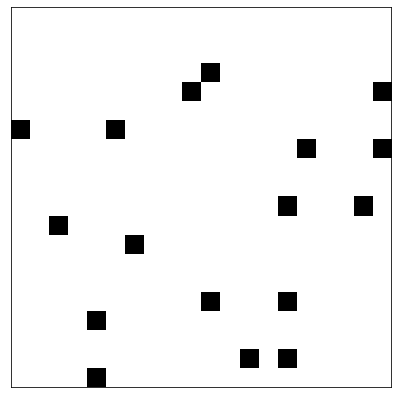

In [110]:
"""Inicia el modelo y empieza a correr el cronómetro"""
start_time = time.time()
dirtyCells = int((DIRTY_PERC/(M*N))*100)
model = CleaningRoomModel(M, N, NUM_AGENTS, dirtyCells)
iterations = 0

"""Se ejecuta el modelo hasta que ya no haya celdas sucias y/o mientras que el tiempo de ejecución sea menor 
al tiempo máximo"""
while dirtyCells > 0 and time.time() - start_time < MAX_TIME:
    model.step()
    dirtyCells = model.dirty_cells
    iterations += 1

"""Crea la animación"""
all_grid = model.datacollector.get_model_vars_dataframe()

fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])

anim = animation.FuncAnimation(fig, animate, frames=iterations+1)
plt.show()

In [111]:
"""Imprime el tiempo de ejecución, el porcentaje de las celdas limpias y el número de movimientos"""
print('Tiempo de ejecución: ',str(datetime.timedelta(seconds=(time.time() - start_time))))
print('Porcentaje de celdas limpias: ',((M*N-dirtyCells)/(M*N))*100)
print('Número de movimientos: ',iterations*NUM_AGENTS)

"""Enseña la animación"""
anim

Tiempo de ejecución:  0:00:02.737759
Porcentaje de celdas limpias:  100.0
Número de movimientos:  4420
